In [181]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import os

# Load datasets

In [229]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load the 2020 and 2024 datasets
vendee_2020_folder = 'data/2020/ranking_history_withwind_2020_per_skipper/'
vendee_2020 = pd.concat(
    [pd.read_csv(os.path.join(vendee_2020_folder,file)) for file in os.listdir(vendee_2020_folder) 
     if file.endswith('.csv')])
vendee_2024 = pd.read_csv('data/2024/ranking_history_withwind_2024.csv')
# Standardize skipper names to have each word start with a capital letter
vendee_2020['skipper'] = vendee_2020['skipper'].str.title()
vendee_2024['skipper'] = vendee_2024['skipper'].str.title()
# Parse dates
vendee_2020['date'] = pd.to_datetime(vendee_2020['date'])
vendee_2024['date'] = pd.to_datetime(vendee_2024['date'])
# There are duplicates in 2020 data
vendee_2020 = vendee_2020.drop_duplicates(subset=['skipper', 'date'])


vendee_2020 = vendee_2020.sort_values(by=['skipper', 'date'])
vendee_2024 = vendee_2024.sort_values(by=['skipper', 'date'])


# Handle irregular time intervals

The 2020 and 2024 datasets have irregular time intervals, which may affect the model’s ability to learn patterns. Uncomment to only keep one data point per day


In [230]:
# Extract one data point per skipper per day at midnight
#vendee_2020["day"] = vendee_2020["date"].dt.date
##vendee_2020 = vendee_2020.groupby(["skipper", "day"]).first().reset_index()
#vendee_2024["day"] = vendee_2024["date"].dt.date
#vendee_2024 = vendee_2024.groupby(["skipper", "day"]).first().reset_index()

# Convert to GeoPandas geometries 

In [231]:
# Convert latitude and longitude into geometric points
vendee_2020['geometry'] = vendee_2020.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
vendee_2024['geometry'] = vendee_2024.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Create GeoDataFrames
vendee_2020_gdf = gpd.GeoDataFrame(vendee_2020, geometry='geometry')
vendee_2024_gdf = gpd.GeoDataFrame(vendee_2024, geometry='geometry')

# Feature engineering 

The goal: Train a model using 2020 data to predict the skipper's direction (heading or movement vector) in the 2024 race based on:
- Current position (latitude, longitude).
- Wind conditions (wind direction, wind speed).
- Additional features like the skipper's past movement (lagged data).

## Direction (bearing)
Compute the direction a skipper moves based on consecutive points


In [232]:
import numpy as np

def calculate_bearing(point1, point2):
    # Function to calculate the bearing between two points
    if point1 is None or point2 is None:
        return None  # Handle NoneType
    lat1, lon1 = np.radians(point1.y), np.radians(point1.x)
    lat2, lon2 = np.radians(point2.y), np.radians(point2.x)
    delta_lon = lon2 - lon1

    x = np.sin(delta_lon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(delta_lon)
    bearing = (np.degrees(np.arctan2(x, y)) + 360) % 360
    return bearing

def add_bearing(df):
    # Add a column for the next geometry
    df['next_geometry'] = df['geometry'].shift(-1)
    # Calculate bearings
    df['bearing'] = df.apply(
        lambda row: calculate_bearing(row['geometry'], row['next_geometry']), axis=1)
    # Drop the helper column
    df.drop(columns=['next_geometry'], inplace=True)
    return df

vendee_2020_gdf = add_bearing(vendee_2020_gdf)
vendee_2024_gdf = add_bearing(vendee_2024_gdf)

Calculate wind alignment with bearing

In [233]:
def add_wind_alignment(df):
    # Calculate wind alignment with bearing
    df['wind_alignment'] = (
    df['winddir'] - df['bearing']
    ).apply(lambda x: (x + 360) % 360)  # Normalize to 0-360 degrees
    return df
vendee_2020_gdf = add_wind_alignment(vendee_2020_gdf)
vendee_2024_gdf = add_wind_alignment(vendee_2024_gdf)


## Lagged features

Generate lagged features to capture past movements.

In [234]:
def add_lagged_features_group(group):
    # Skip groups with fewer rows than the maximum lag
    if len(group) <= 3:  # Adjust based on the maximum lag
        return group

    group['lat_lag_1'] = group['latitude'].shift(1)
    group['lon_lag_1'] = group['longitude'].shift(1)
    group['bearing_lag_1'] = group['bearing'].shift(1)
    return group

def add_lagged_features_df(df):
    # Group by skipper and create lagged features
    df = df.groupby('skipper').apply(add_lagged_features_group)
    return df

vendee_2020_gdf = add_lagged_features_df(vendee_2020_gdf)
vendee_2024_gdf = add_lagged_features_df(vendee_2024_gdf)


# Drop rows with NaN values after lagging (only within the required features)
vendee_2020_gdf = vendee_2020_gdf.dropna(subset=['lat_lag_1', 'lon_lag_1', 'bearing_lag_1'])
vendee_2024_gdf = vendee_2024_gdf.dropna(subset=['lat_lag_1', 'lon_lag_1', 'bearing_lag_1'])

# Check resulting DataFrame
print(f"Number of rows after adding lagged features: {len(vendee_2020_gdf)}")
vendee_2020_gdf = vendee_2020_gdf.dropna(subset=['bearing'])
print(f"Number of rows after adding lagged features: {len(vendee_2024_gdf)}")
vendee_2024_gdf = vendee_2024_gdf.dropna(subset=['bearing'])

Number of rows after adding lagged features: 14147
Number of rows after adding lagged features: 1312


/var/folders/5j/ddgv841d4x169jlw5sq1jc340000gn/T/ipykernel_23574/627770755.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('skipper').apply(add_lagged_features_group)
/var/folders/5j/ddgv841d4x169jlw5sq1jc340000gn/T/ipykernel_23574/627770755.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('skipper').apply(add_lagged_features_group)


In [236]:
print(vendee_2024_gdf['bearing'].isna().sum())


0


# Train the model on 2020 data

In [237]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Features and target
features = ['latitude', 'longitude', 'wind_alignment', 'lat_lag_1', 'lon_lag_1', 'bearing_lag_1']
target = 'bearing'

X = vendee_2020_gdf[features]
y = vendee_2020_gdf[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [238]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Train a regression model
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Evaluate the model
y_pred = regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Mean Absolute Error (MAE): 21.42


# Predict 2024 bearings

In [239]:
# Predict bearings
X_2024 = vendee_2024_gdf[features]
vendee_2024_gdf['predicted_bearing'] = regressor.predict(X_2024)

# Inspect predictions
print(vendee_2024_gdf[['latitude', 'longitude', 'predicted_bearing']].head())

                  latitude  longitude  predicted_bearing
skipper                                                 
Alan Roura 184   45.305000  -4.421667         234.531223
           300   44.901167  -5.402333         247.904112
           1212  44.528667  -6.377833         259.092568
           855   43.980000  -7.320333         222.147278
           467   44.240500  -8.631333         210.200585


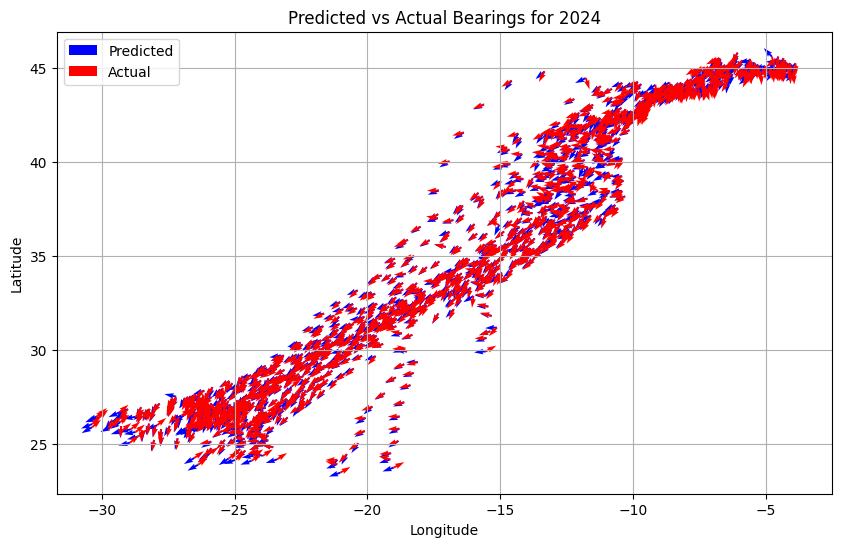

In [240]:
import matplotlib.pyplot as plt
import numpy as np

# Plot actual vs predicted bearings
plt.figure(figsize=(10, 6))
plt.quiver(
    vendee_2024_gdf['longitude'], vendee_2024_gdf['latitude'], 
    np.cos(np.radians(vendee_2024_gdf['predicted_bearing'])),
    np.sin(np.radians(vendee_2024_gdf['predicted_bearing'])),
    color='blue', label='Predicted'
)
plt.quiver(
    vendee_2024_gdf['longitude'], vendee_2024_gdf['latitude'], 
    np.cos(np.radians(vendee_2024_gdf['bearing'])),
    np.sin(np.radians(vendee_2024_gdf['bearing'])),
    color='red', label='Actual'
)
plt.legend()
plt.title('Predicted vs Actual Bearings for 2024')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()


# Explore the route of a chosen skipper

In [241]:
vendee_2024_gdf.skipper.unique()

array(['Alan Roura', 'Antoine Cornic', 'Arnaud Boissières',
       'Benjamin Dutreux', 'Benjamin Ferré', 'Boris Herrmann',
       'Charlie Dalin', 'Clarisse Crémer', 'Conrad Colman',
       'Damien Seguin', 'Denis Van Weynbergh', 'Fabrice Amedeo',
       'Giancarlo Pedote', 'Guirec Soudée', 'Isabelle Joschke',
       'Jean Le Cam', 'Jingkun Xu', 'Justine Mettraux', 'Jérémie Beyou',
       'Kojiro Shiraishi', 'Louis Burton', 'Louis Duc', 'Manuel Cousin',
       'Maxime Sorel', 'Nicolas Lunven', 'Oliver Heer', 'Paul Meilhat',
       'Pip Hare', 'Romain Attanasio', 'Sam Goodchild', 'Samantha Davies',
       'Szabolcs Weöres', 'Sébastien Marsset', 'Sébastien Simon',
       'Tanguy Le Turquais', 'Thomas Ruyant', 'Violette Dorange',
       'Yannick Bestaven', 'Yoann Richomme', 'Éric Bellion'], dtype=object)

In [242]:
chosen_skipper = 'Pip Hare'

In [243]:
# Filter data for Pip Hare and sort by date
chosen_skipper_data = vendee_2024_gdf[vendee_2024_gdf['skipper'] == chosen_skipper].sort_values(by='date')

# Get the last available data point
latest_data = chosen_skipper_data.iloc[-1]


In [244]:
# Ensure the CRS is set correctly
vendee_2020_gdf = vendee_2020_gdf.set_crs("EPSG:4326")

# Shift the geometry column for consecutive points
vendee_2020_gdf['next_geometry'] = vendee_2020_gdf['geometry'].shift(-1)

# Calculate distances (in degrees, needs conversion to kilometers)
vendee_2020_gdf['distance'] = vendee_2020_gdf.apply(
    lambda row: row['geometry'].distance(row['next_geometry']) if row['next_geometry'] else None, axis=1
)

# Drop helper column
vendee_2020_gdf.drop(columns=['next_geometry'], inplace=True)


In [251]:
# Prepare the input features for the prediction
features = ['latitude', 'longitude', 'wind_alignment', 'lat_lag_1', 'lon_lag_1', 'bearing_lag_1']
latest_features = latest_data[features].values.reshape(1, -1)

# Predict the next position's bearing
predicted_bearing = regressor.predict(latest_features)[0]

# Predict the distance traveled in one day
mean_daily_distance = vendee_2020_gdf['distance'].mean()  
predicted_lat = latest_data['latitude'] + mean_daily_distance * np.cos(np.radians(predicted_bearing))
predicted_lon = latest_data['longitude'] + mean_daily_distance * np.sin(np.radians(predicted_bearing))


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## Interactive map

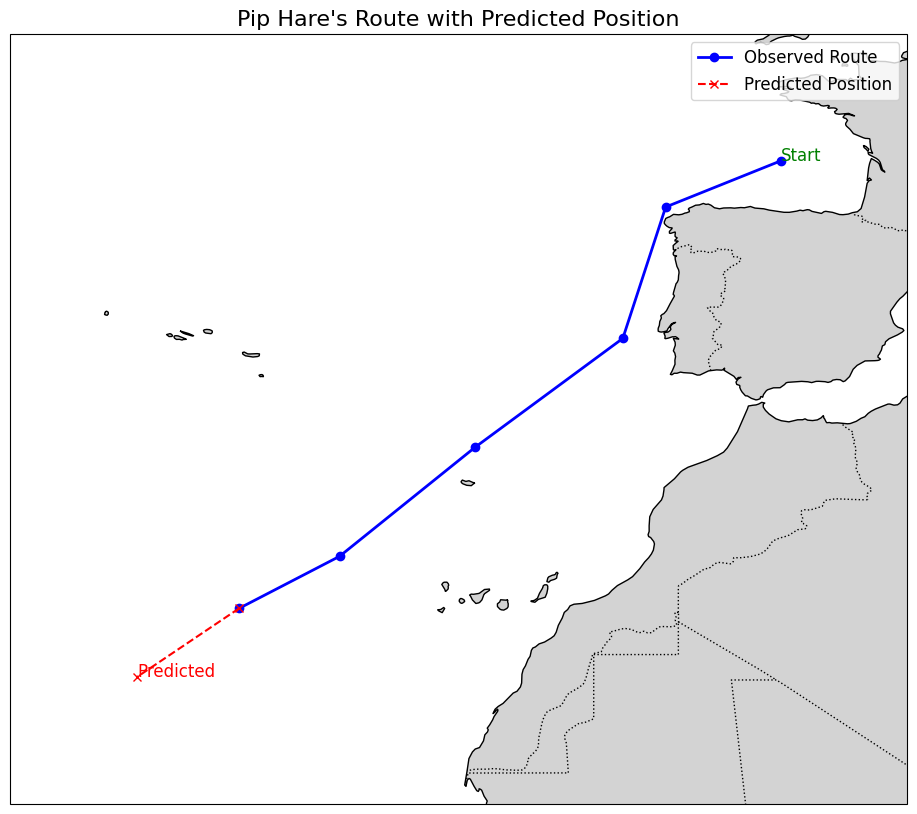

In [257]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Example data: Pip Hare's observed positions
chosen_skipper_data["day"] = chosen_skipper_data["date"].dt.date
chosen_skipper_data = chosen_skipper_data.sort_values(by='date')  # Ensure data is sorted by date
chosen_skipper_data_plot = chosen_skipper_data.groupby([ "day"]).first().reset_index()
# Only keep midnight data for more informative graph
latitudes = chosen_skipper_data_plot['latitude'].tolist()
longitudes = chosen_skipper_data_plot['longitude'].tolist()

# Add the predicted position
predicted_lat = latest_data['latitude'] + mean_daily_distance * np.cos(np.radians(predicted_bearing))
predicted_lon = latest_data['longitude'] + mean_daily_distance * np.sin(np.radians(predicted_bearing))

# Append the predicted position to the observed positions
latitudes.append(predicted_lat)
longitudes.append(predicted_lon)

# Calculate bounding box with a margin
margin = 5  # degrees of margin around the route
lat_min = min(latitudes) - margin
lat_max = max(latitudes) + margin
lon_min = min(longitudes) - margin
lon_max = max(longitudes) + margin

# Set up the map with Cartopy
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add world map features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set extent to zoom in on Pip Hare's route
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot observed route
ax.plot(longitudes[:-1], latitudes[:-1], color='blue', linewidth=2, marker='o', label="Observed Route")

# Plot the predicted position
ax.plot(longitudes[-2:], latitudes[-2:], color='red', linestyle='--', marker='x', label="Predicted Position")

# Add labels and legend
plt.title("Pip Hare's Route with Predicted Position", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.legend(fontsize=12)
plt.grid()

# Add annotations for the start and predicted position
ax.text(longitudes[0], latitudes[0], "Start", fontsize=12, color='green', transform=ccrs.PlateCarree())
ax.text(predicted_lon, predicted_lat, "Predicted", fontsize=12, color='red', transform=ccrs.PlateCarree())

plt.show()


In [258]:
import folium
from folium import plugins

# Create a map centered on the last known position
m = folium.Map(location=[latest_data['latitude'], latest_data['longitude']], zoom_start=5)

for _, row in chosen_skipper_data.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Pip Hare 2024 (Observed) | Date: {row['date']}"
    ).add_to(m)
latest_date_2024 = vendee_2024['date'].max()
latest_day = latest_date_2024.day
latest_month = latest_date_2024.month
#pip_hare_data_2020_plot = pip_hare_data_2020[(pip_hare_data_2020['date'].dt.year < 2021) & (pip_hare_data_2020['date'].dt.day <= latest_day) & (pip_hare_data_2020['date'].dt.month <= latest_month)]
#for _, row in pip_hare_data_2020_plot.iterrows():
#    folium.Marker(
#        location=[row['latitude'], row['longitude']],
#        popup=f"Pip Hare 2020 | Date: {row['date']}",
#        icon=folium.Icon(color="green")
#    ).add_to(m)

# Add current position
folium.Marker(
    location=[latest_data['latitude'], latest_data['longitude']],
    popup="Current Position"
).add_to(m)

# Add predicted positions
#for i, row in future_df.iterrows():
#    folium.Marker(
#        location=[row['latitude'], row['longitude']],
#        popup=f"Day {i+1} Prediction",
#        icon=folium.Icon(color="red")
#    ).add_to(m)
# Add current position
folium.Marker(
    location=[latest_data['latitude'], latest_data['longitude']],
    popup="Current Position",
    icon=folium.Icon(color="black", icon="star")
).add_to(m)
# Add marker for the predicted position
folium.Marker(
    location=[predicted_lat, predicted_lon],
    popup="Predicted Position (Next Day)",
    icon=folium.Icon(color="red", icon="flag")
).add_to(m)
folium.PolyLine(
    locations=[[latest_data['latitude'], latest_data['longitude']], [predicted_lat, predicted_lon]],
    color="green",
    weight=2.5,
    opacity=0.8
).add_to(m)
# Add a legend
legend_html = f'''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px; height: 120px; 
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; padding: 10px;">
    <b>{chosen_skipper}</b><br>
    <i style="background: blue; width: 10px; height: 10px; display: inline-block;"></i> 2024 Route<br>
    <i style="background: green; width: 10px; height: 10px; display: inline-block;"></i> 2020 Route<br>
    <i style="background: red; width: 10px; height: 10px; display: inline-block;"></i> Predicted Route<br>
    <i style="background: black; width: 10px; height: 10px; display: inline-block;"></i> Current Position
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))
# Save and display the map
#m.save("predicted_route.html")
m
